In [15]:
# Removes Document Identifier, Removes Topic Label, Returns List of Labels and Documents
def clean_data(file_name):
    with open(file_name, "r") as f:
        all_docs = []
        all_labels = []
        for line in f:
            line_list = list(line.split(" "))
            line_list.pop(0)
            line_list.pop(1)
            line_list.pop(len(line_list)-1)
            all_labels.append(line_list.pop(0))
            all_docs.append(" ".join(line_list))
        return all_docs,all_labels

# Takes in documents, labels and returns two lists corresponding to training and test data an labels
def tt_split_data(all_docs, all_labels):
    split_point = int(0.80 * len(all_docs))
    test_data = [all_docs[split_point:], all_labels[split_point:]]
    training_data = [all_docs[:split_point], all_labels[:split_point]]
    return training_data, test_data

# Encodes Labels
from sklearn import preprocessing
import numpy as np
def encode_labels(labels):
    label_encoder = preprocessing.LabelEncoder()
    return list(label_encoder.fit_transform(labels))

#Generate Performance Metrics

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def print_confusion_matrix(true_labels, predicted_labels, file_name):
    cm = confusion_matrix(true_labels, predicted_labels)#.ravel()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
    fig = disp.plot().figure_ 
    fig.savefig(file_name)
    with open("my_file.txt", 'w') as f:
        f.write(np.array2string(cm, separator=', '))
    
    
def print_metrics(true_labels, predicted_labels):  
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"Accuracy: {accuracy}")
    
def print_predictions(predicted_labels, start_line):
    for i in range(0, len(predicted_labels)):
        print(f"{start_line + i},{predicted_labels[i]}")
        
def print_output(true_labels, predicted_labels, start_line, file_name):
    cm = confusion_matrix(true_labels, predicted_labels)#.ravel()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
    fig = disp.plot().figure_ 
    fig.savefig("cm.png")    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    f = open(file_name, "a")
    for i in range(0, len(predicted_labels)):
        f.write(f"{start_line + i},{predicted_labels[i]}\n") 
    f.write("\nConfusion Matrix\n")
    f.write(np.array2string(cm, separator=', '))
    f.write("\n")   
    f.write(f"\nPrecision: {precision}\n")
    f.write(f"Recall: {recall}\n")
    f.write(f"F1: {f1}\n")
    f.write(f"\nAccuracy: {accuracy}\n")
    f.flush()
    f.close()

In [16]:
all_docs, all_labels = clean_data("all_sentiment_shuffled.txt")
training, test = tt_split_data(all_docs, all_labels)

training_lines_nos=[0 + 1, len(training[0])]
test_lines_nos = [training_lines_nos[1] + 1, training_lines_nos[1] + len(test[0])]


training[1] = encode_labels(training[1])
test[1] = encode_labels(test[1])

In [17]:
#Feature Extraction (TFIDF)
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
tfidf_training = [tvec.fit_transform(training[0]).toarray(), training[1]]
tfidf_test = [tvec.transform(test[0]).toarray(), test[1]]                                                      


#Feature Extraction (Count Vector)
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
count_training = [cvec.fit_transform(training[0]).toarray(), training[1]]
count_test = [cvec.transform(test[0]).toarray(), test[1]]  

In [18]:
#Running Decision Tree on count vectors without hyperparameter tuning
#import joblib
#from sklearn import tree
#cdtc = tree.DecisionTreeClassifier(criterion="entropy")
#cdtc.fit(count_training[0], count_training[1])
#joblib.dump(cdtc, "dt_count_no_tuning.pkl")

Precision: 0.6630615640599001
Recall: 0.6912402428447528
F1: 0.6768577494692145
Accuracy: 0.6806546370121695


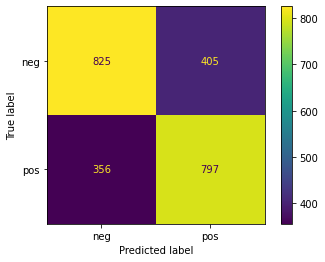

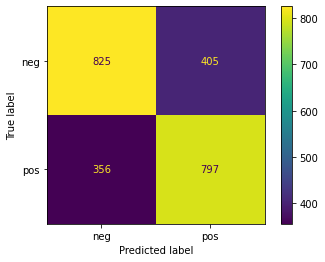

In [19]:
import joblib
from sklearn import tree
cdtc = joblib.load("dt_count_no_tuning.pkl")
predicted_labels = cdtc.predict(count_test[0])
print_confusion_matrix(count_test[1], predicted_labels, "dt_count-test.png")
print_metrics(count_test[1], predicted_labels)
print_output(count_test[1], predicted_labels, test_lines_nos[0], "dt_count-test.txt")

Precision: 0.6682926829268293
Recall: 0.7129228100607112
F1: 0.6898866974402014
Accuracy: 0.6898866974402015


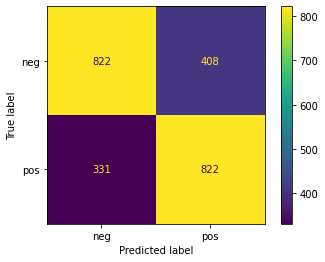

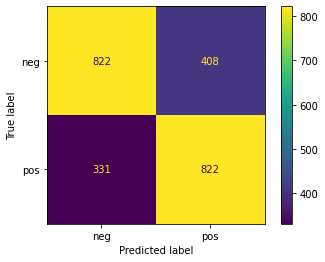

In [20]:
import joblib
optimized_cdtc = joblib.load("gs_depth_60_79.pkl").best_estimator_

predicted_labels = optimized_cdtc.predict(count_test[0])
print_confusion_matrix(count_test[1], predicted_labels, "o_dt_count-test.png")
print_metrics(count_test[1], predicted_labels)
print_output(count_test[1], predicted_labels, test_lines_nos[0], "o_dt_count-test.txt")

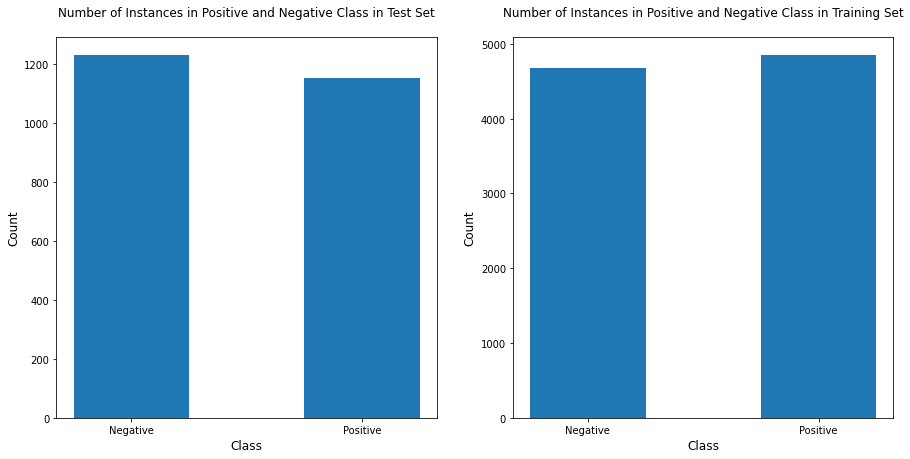

In [21]:
#Plot distribution of number of instances in each class
import matplotlib.pyplot as plt

classes = ["Negative", "Positive"]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))

test_counts = [test[1].count(0), test[1].count(1)]
ax1.bar(classes, test_counts, width=0.5)
ax1.set_title("Number of Instances in Positive and Negative Class in Test Set\n", fontsize=12)
ax1.set_xlabel("Class", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)

training_counts = [training[1].count(0), training[1].count(1)]
ax2.bar(classes, training_counts, width=0.5)
ax2.set_title("Number of Instances in Positive and Negative Class in Training Set\n", fontsize=12)
ax2.set_xlabel("Class", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)

plt.savefig("distribution_of_training_test.jpg")